1 Author
Student Name:Rui Chen
Student ID:210978863

2 Problem formulation

In this task,I plan to do a multi classification based on genki4k dataset to classify these people with their gender and color and get six catagories.Because I found that this dataset covers all races and genders, and by labelling it, I was able to get the machine to learn its features then do multi-classification.

3 Machine Learning pipeline

There are four main step to do the task:data preprocess,split data,train the model,test(evaluate) the model.

In this task, there are also other algorithm like SVM, decision tree and so on to do multi classification, but I still use resnet34 to do, most of steps are same as basic part, we just need to adjust our datasets and make some changes of our model.

4 Transformation Stage

Same as basic part, we use 68_face_landmarks to extract human face, it can be seen like a mild data augmentation because we extract useful information to fit a model. I do a simple geometric transformation and resize.

In [ ]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
plt.show("genki4k/files/file0001.jpg")
plt.show("genki4k/files(preprocess)/file0001.jpg")

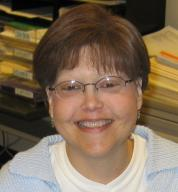

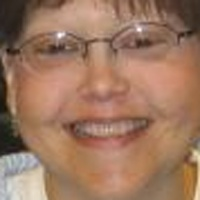

In [17]:
from IPython.display import Image, display

# File paths for images
image_path1 = 'genki4k/files/file0001.jpg'
image_path2 = 'genki4k/files(preprocess)/file1.jpg'

# Display the two images
display(Image(filename=image_path1))
display(Image(filename=image_path2))

5 Modelling

In [ ]:
import os
import torch
import torch.nn as nn
from resnet import resnet34


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
    model_weight_path = "./resnet34-pre.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)

    net = resnet34()
    net.load_state_dict(torch.load(model_weight_path, map_location=device))
    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 5)

if __name__ == '__main__':
    main()

In multi classification task, we use a another package "resNet34_advanced" in my folder which is a pre-trained model. 

In [ ]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
     Note: In the original paper, on the main branch of the dashed residual structure, the first 1x1 convolutional layer has a step of 2 and the second 3x3 convolutional layer has a step of 1.
    However, in the official pytorch implementation, the first 1x1 convolutional layer has a step of 1, and the second 3x3 convolutional layer has a step of 2.
    The advantage of doing this is that it can improve the accuracy of top1 by about 0.5%.
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

6 Methodology

Step 1 preprocess (This is explained in detail in Part 7)

Step 2 split data

I split the dataset according to my own labels, the fifth means gender,"0" is woman and "1" means man; the sixth value in a line means color,"1" means yellow, "2" means white and "3" means black.

In [6]:
import os
import shutil
import random

def split_into_two(i=None):
    
    data_folder = "genki4k/files(preprocess)"
    label_file= "genki4k/labels.txt"

    # create output folders
    os.makedirs("genki4k/files(splitdata)/woman_y", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/woman_w", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/woman_b", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/man_y", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/man_w", exist_ok=True)
    os.makedirs("genki4k/files(splitdata)/man_b", exist_ok=True)
    # get all the files
    files = os.listdir(data_folder)

    # read label.txt
    with open(label_file, 'r') as label_file:
        lines = label_file.readlines()

    for i, line in enumerate(lines):
        # split each line
        values = line.strip().split()
        fnames = ['file{}.jpg'.format(i + 1)]

        # make sure at least six value
        if len(values) >= 6:
            fifth_value = values[4]
            sixth_value = values[5]
        
            # When the fifth number is 0 and sixth is 1，copy to the woman_y
            if (fifth_value == '0')& (sixth_value == '1'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/woman_y", fname)
                      shutil.copyfile(src, dst)
            if (fifth_value == '0')& (sixth_value == '2'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/woman_w", fname)
                      shutil.copyfile(src, dst)
            if (fifth_value == '0')& (sixth_value == '3'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/woman_b", fname)
                      shutil.copyfile(src, dst)
            if (fifth_value == '1')& (sixth_value == '1'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/man_y", fname)
                      shutil.copyfile(src, dst)
            if (fifth_value == '1')& (sixth_value == '2'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/man_w", fname)
                      shutil.copyfile(src, dst)
            if (fifth_value == '1')& (sixth_value == '3'):
                 for fname in fnames:
                      src = os.path.join("genki4k/files(preprocess)", fname)
                      dst = os.path.join("genki4k/files(splitdata)/man_b", fname)
                      shutil.copyfile(src, dst)

    print("split the dataset done!")


def split_into_three():
    split_ratio = [0.6, 0.2, 0.2]

    output_folder = ["genki4k/files(splitdata)/train", "genki4k/files(splitdata)/test",
                     "genki4k/files(splitdata)/val"]
    for folder in output_folder:
        os.makedirs(os.path.join(folder, "man_b"), exist_ok=True)
        os.makedirs(os.path.join(folder, "man_w"), exist_ok=True)
        os.makedirs(os.path.join(folder, "man_y"), exist_ok=True)
        os.makedirs(os.path.join(folder, "woman_w"), exist_ok=True)
        os.makedirs(os.path.join(folder, "woman_b"), exist_ok=True)
        os.makedirs(os.path.join(folder, "woman_y"), exist_ok=True)

    # split man_b
    man_b_files = os.listdir("genki4k/files(splitdata)/man_b")
    random.shuffle(man_b_files)
    total_man_b_files = len(man_b_files)
    split_index_man_b = [int(total_man_b_files * split_ratio[0]),
                         int(total_man_b_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(man_b_files):
        if i < split_index_man_b[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_b", file),
                        os.path.join("genki4k/files(splitdata)/train", "man_b", file))
        elif i < split_index_man_b[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_b", file),
                        os.path.join("genki4k/files(splitdata)/test", "man_b", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_b", file),
                        os.path.join("genki4k/files(splitdata)/val", "man_b", file))

    man_w_files = os.listdir("genki4k/files(splitdata)/man_w")
    random.shuffle(man_w_files)
    total_man_w_files = len(man_w_files)
    split_index_man_w = [int(total_man_w_files * split_ratio[0]),
                         int(total_man_w_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(man_w_files):
        if i < split_index_man_w[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_w", file),
                        os.path.join("genki4k/files(splitdata)/train", "man_w", file))
        elif i < split_index_man_w[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_w", file),
                        os.path.join("genki4k/files(splitdata)/test", "man_w", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_w", file),
                        os.path.join("genki4k/files(splitdata)/val", "man_w", file))

    man_y_files = os.listdir("genki4k/files(splitdata)/man_y")
    random.shuffle(man_y_files)
    total_man_y_files = len(man_y_files)
    split_index_man_y = [int(total_man_y_files * split_ratio[0]),
                         int(total_man_y_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(man_y_files):
        if i < split_index_man_y[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_y", file),
                        os.path.join("genki4k/files(splitdata)/train", "man_y", file))
        elif i < split_index_man_y[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_y", file),
                        os.path.join("genki4k/files(splitdata)/test", "man_y", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/man_y", file),
                        os.path.join("genki4k/files(splitdata)/val", "man_y", file))

    # split woman_b folder
    woman_b_files = os.listdir("genki4k/files(splitdata)/woman_b")
    random.shuffle(woman_b_files)
    total_woman_b_files = len(woman_b_files)
    split_index_woman_b = [int(total_woman_b_files * split_ratio[0]),
                           int(total_woman_b_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(woman_b_files):
        if i < split_index_woman_b[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_b", file),
                        os.path.join("genki4k/files(splitdata)/train", "woman_b", file))
        elif i < split_index_woman_b[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_b", file),
                        os.path.join("genki4k/files(splitdata)/test", "woman_b", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_b", file),
                        os.path.join("genki4k/files(splitdata)/val", "woman_b", file))

    woman_w_files = os.listdir("genki4k/files(splitdata)/woman_w")
    random.shuffle(woman_w_files)
    total_woman_w_files = len(woman_w_files)
    split_index_woman_w = [int(total_woman_w_files * split_ratio[0]),
                           int(total_woman_w_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(woman_w_files):
        if i < split_index_woman_w[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_w", file),
                        os.path.join("genki4k/files(splitdata)/train", "woman_w", file))
        elif i < split_index_woman_w[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_w", file),
                        os.path.join("genki4k/files(splitdata)/test", "woman_w", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_w", file),
                        os.path.join("genki4k/files(splitdata)/val", "woman_w", file))

    woman_y_files = os.listdir("genki4k/files(splitdata)/woman_y")
    random.shuffle(woman_y_files)
    total_woman_y_files = len(woman_y_files)
    split_index_woman_y = [int(total_woman_y_files * split_ratio[0]),
                           int(total_woman_y_files * (split_ratio[0] + split_ratio[1]))]

    for i, file in enumerate(woman_y_files):
        if i < split_index_woman_y[0]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_y", file),
                        os.path.join("genki4k/files(splitdata)/train", "woman_y", file))
        elif i < split_index_woman_y[1]:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_y", file),
                        os.path.join("genki4k/files(splitdata)/test", "woman_y", file))
        else:
            shutil.copy(os.path.join("genki4k/files(splitdata)/woman_y", file),
                        os.path.join("genki4k/files(splitdata)/val", "woman_y", file))

    print("split into train,test or val done!")

if __name__ == "__main__":
    split_into_two()
    split_into_three()

split the dataset done!
split into train,test or val done!


Step 3 Train

In [1]:
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm

from resnet import resnet34


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        "val": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

    data_root = os.path.abspath(os.path.join(os.getcwd(), "../Advanced"))  # get data root path
    image_path = os.path.join(data_root, "genki4k", "files(splitdata)")  # genki4k data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices_advanced.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = resnet34()
    # load pretrain weights
    # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
    model_weight_path = "./resnet34-pre.pth"
    assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location='cpu'))
    # for param in net.parameters():
    #     param.requires_grad = False

    # change fc layer structure
    in_channel = net.fc.in_features
    net.fc = nn.Linear(in_channel, 6)
    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.0001)

    epochs = 10
    best_acc = 0.0
    save_path = './resNet34_advanced.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits = net(images.to(device))
            loss = loss_function(logits, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                # loss = loss_function(outputs, test_labels)
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == '__main__':
    main()

using cpu device.
Using 8 dataloader workers every process
using 476 images for training, 162 images for validation.
valid epoch[1/10]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.03s/it]
[epoch 1] train_loss: 1.418  val_accuracy: 0.549
valid epoch[2/10]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.44s/it]
[epoch 2] train_loss: 1.061  val_accuracy: 0.543
valid epoch[3/10]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:16<00:00,  1.47s/it]
[epoch 3] train_loss: 0.880  val_accuracy: 0.667
valid epoch[4/10]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.04it/s]
[epoch 4] train_loss: 0.784  val_accuracy: 0.648
valid epoch[5/10]: 100%|███████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.06it/s]
[epoch 5] train_loss: 0.703  val_accuracy: 0.642
valid epoch[6/10]: 100%|██████████████

Step 4 Test (The detailed process is on part 8)

**7 Dataset**

In this task, at first, I labelled each image myself according to the pre-processed images. In the file "labels.txt", I typed two labels in the fifth and sixth positions of each line, the first label represents gender, with "0" for women and "0" for men. The second label is for ethnicity, yellow is "1", white is "2", black is "3 The second label is ethnicity, with "1" for yellow, "2" for white, and "3" for black. With the labels, supervised learning is possible.
But after I typed in eight hundred labels and tried to classify them, I realised that the dataset was not ethnically homogeneous, especially when you add in the gender; out of the eight hundred graphs, there are two-thirds as many white men as white women, and only one-third as many yellow men as there are white men. At the same time, we do not have a large amount of data, so it will have a large impact on the accuracy, in order to reduce the error caused by this kind of dataset, I manually selected and categorised a part of the photos from the dataset in an attempt to make the dataset a little bit more evenly distributed.
As for the pre-processing of each image, it is the same as that of task1, i.e. face extraction based on 68_face_landmarks

In [9]:
import dlib          
import numpy as np   
import cv2           
import os
 
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
 
path_read = "genki4k/files"
num=0
for file_name in os.listdir(path_read):
    
    all_path = (path_read + "/" + file_name)
    img = cv2.imdecode(np.fromfile(all_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img_shape=img.shape
    img_height=img_shape[0]
    img_width=img_shape[1]
   
    os.makedirs("genki4k/files(preprocess)", exist_ok=True)
    path_save = "genki4k/files(preprocess)"

    dets = detector(img , 1)
    for k, d in enumerate(dets):
        if len(dets) > 1:
            continue
        num=num+1
        
        pos_start = tuple([d.left(), d.top()])
        pos_end = tuple([d.right(), d.bottom()])
 
        height = d.bottom()-d.top()
        width = d.right()-d.left()
 
        img_blank = np.zeros((height, width, 3), np.uint8)
        for i in range(height):
            if d.top()+i >= img_height:  
                continue
            for j in range(width):
                if d.left()+j >= img_width:  
                    continue
                img_blank[i][j] = img[d.top()+i][d.left()+j]
        img_blank = cv2.resize(img_blank, (200, 200), interpolation=cv2.INTER_CUBIC)
 
        cv2.imencode('.jpg', img_blank)[1].tofile(path_save+"/"+"file"+str(num)+".jpg") # 正确方法
 
print("processing done!")

processing done!


8 Result 
Test the model on the 'test' dataset.The 'prob' is the probability that the given image belongs to the class.

In [5]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms

from resnet import resnet34


def main(imgs_root):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # load image
    # 指向需要遍历预测的图像文件夹
    # imgs_root = "genki4k/files(splitdata)/test/unsmile"
    # imgs_root = "genki4k/files(splitdata)/test/smile"
    assert os.path.exists(imgs_root), f"file: '{imgs_root}' dose not exist."
    # 读取指定文件夹下所有jpg图像路径
    img_path_list = [os.path.join(imgs_root, i) for i in os.listdir(imgs_root) if i.endswith(".jpg")]

    # read class_indict
    json_path = './class_indices_advanced.json'
    assert os.path.exists(json_path), f"file: '{json_path}' dose not exist."

    json_file = open(json_path, "r")
    class_indict = json.load(json_file)

    # create model
    model = resnet34(num_classes=6).to(device)

    # load model weights
    weights_path = "./resNet34_advanced.pth"
    assert os.path.exists(weights_path), f"file: '{weights_path}' dose not exist."
    model.load_state_dict(torch.load(weights_path, map_location=device))

    # prediction
    model.eval()
    batch_size = 8  # 每次预测时将多少张图片打包成一个batch
    with torch.no_grad():
        for ids in range(0, len(img_path_list) // batch_size):
            img_list = []
            for img_path in img_path_list[ids * batch_size: (ids + 1) * batch_size]:
                assert os.path.exists(img_path), f"file: '{img_path}' dose not exist."
                img = Image.open(img_path)
                img = data_transform(img)
                img_list.append(img)

            # batch img
            # 将img_list列表中的所有图像打包成一个batch
            batch_img = torch.stack(img_list, dim=0)
            # predict class
            output = model(batch_img.to(device)).cpu()
            predict = torch.softmax(output, dim=1)
            probs, classes = torch.max(predict, dim=1)
            for idx, (pro, cla) in enumerate(zip(probs, classes)):
                print("image: {}  class: {}  prob: {:.3}".format(img_path_list[ids * batch_size + idx],
                                                                 class_indict[str(cla.numpy())],
                                                                 pro.numpy()))


if __name__ == '__main__':
    main("genki4k/files(splitdata)/test/man_b")
    main("genki4k/files(splitdata)/test/man_w")
    main("genki4k/files(splitdata)/test/man_y")
    main("genki4k/files(splitdata)/test/woman_b")
    main("genki4k/files(splitdata)/test/woman_w")
    main("genki4k/files(splitdata)/test/woman_y")

image: genki4k/files(splitdata)/test/man_w\file130.jpg  class: man_w  prob: 0.668
image: genki4k/files(splitdata)/test/man_w\file132.jpg  class: man_w  prob: 0.779
image: genki4k/files(splitdata)/test/man_w\file157.jpg  class: woman_w  prob: 0.503
image: genki4k/files(splitdata)/test/man_w\file16.jpg  class: man_w  prob: 0.993
image: genki4k/files(splitdata)/test/man_w\file186.jpg  class: man_w  prob: 0.999
image: genki4k/files(splitdata)/test/man_w\file194.jpg  class: man_w  prob: 0.955
image: genki4k/files(splitdata)/test/man_w\file204.jpg  class: woman_w  prob: 0.804
image: genki4k/files(splitdata)/test/man_w\file221.jpg  class: man_w  prob: 0.999
image: genki4k/files(splitdata)/test/man_w\file255.jpg  class: man_w  prob: 0.989
image: genki4k/files(splitdata)/test/man_w\file277.jpg  class: man_w  prob: 0.992
image: genki4k/files(splitdata)/test/man_w\file280.jpg  class: man_w  prob: 0.913
image: genki4k/files(splitdata)/test/man_w\file283.jpg  class: man_w  prob: 0.929
image: genki4

In this task, compared with basic part, we can easily see that the test accuracy is lower,easier to mis-classify.I think there are some reasons:
1.The useful data is small, yellow woman and yellow man has relativly small data, about 120 images, More data for training will significantly improve accuracy.
2.The distribution of data is not even, yellow people in the dataset are only a quarter of white people, it will affect prosterior probability, although we don't the exact prosterior probability. But obviously this affects the feature extraction.
3.Each image is affected by light and shadow and pixels plus the fact that mixed races mix the characteristics of each race, requiring better predictions based on a larger and more comprehensive dataset.

A multi-classification task is quite similar to binary classification, labels are also very important in machine learning and nowdays it's an essential step.
1. ResNet-34 exhibits powerful feature extraction capabilities, supported by its deep architecture and residual connections. This enables the network to learn more abstract and complex features, making it highly effective for tasks such as image classification.
2.ResNet-34 is suitable for medium-sized and moderately complex image classification problems. For larger datasets or more intricate tasks, consideration of deeper networks may be necessary.
3.ResNet-34 demonstrates good generalization ability across various image classification tasks. Due to its intermediate depth, it might perform well even on smaller datasets without significant risk of overfitting.